In [147]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.models.TTree.Model_TTree_v20
mcsangle:pl.DataFrame
dfana:pl.DataFrame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
import uproot.models
import uproot.models.TTree


def get_dump(fname):

    # mcstree:uproot.models.TTree.Model_TTree_v20
    mcstree = uproot.open(fname)

    arr={}
    
    alldata:ak.Array
    alldata = mcstree.arrays()
    top = len(alldata)

    klist = ['run','subrun','event','isContained','len','trkpdg','E','Ereco','fitstatus', 'lenseg']
    nevts = [len(v) for v in alldata['azx'][:top]]
    for c in klist:
        if c in alldata.fields:
            a  = alldata[c][:top]
            arr[c] = np.repeat(a,nevts)
        
    klist = ['azx','azy','avalid', 'Ei_true', 'ei']
    for c in klist:
        a  = alldata[c][:top]
        arr[c] = ak.ravel(a)
    
    tangles = pd.DataFrame(arr)
    return pl.from_pandas(tangles)

mcs = get_dump('../data/mcparticle_dump_with_Eitrue_fix_checkfit.root:t1')
mcs = mcs.with_columns(
    p = (pl.col("E")**2 - 0.1057**2).sqrt()
)
mcs = mcs.with_columns(
    stepei = pl.col('ei'),
    ei = (pl.col('ei').cum_count().over(selection_events()) - 1)*10
)
# mcsangle = mcsangle.with_columns(
#     ei = pl.col('ei'),
#     ej = pl.col('ej'),
# # ).with_columns(
# #     Ei = pl.col("E") - pl.col("ei")
# ).sort(selection_events())

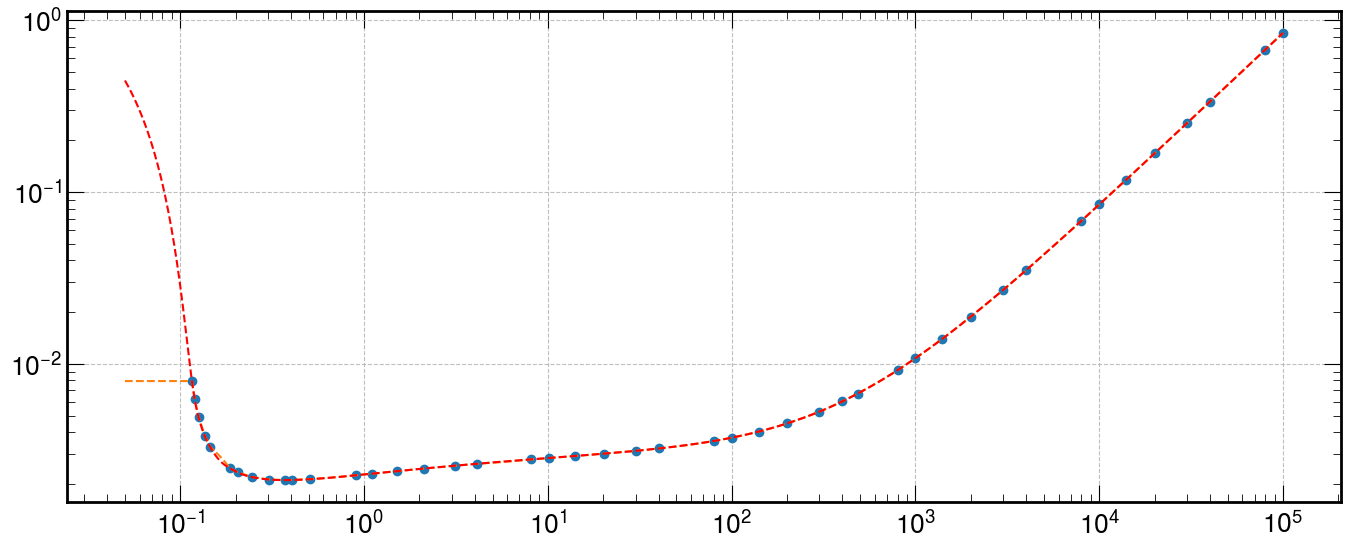

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


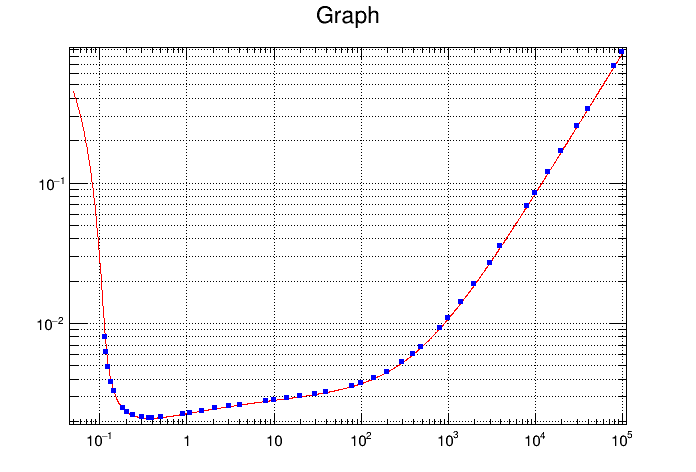

In [345]:
# 
dEdx = np.array([
    5.687, 4.461, 3.502, 2.731, 2.340, 1.771, 1.670, 1.570, 1.519, 1.508,
    1.510, 1.526, 1.610, 1.645, 1.700, 1.761, 1.829, 1.877, 1.991, 2.028,
    2.084, 2.149, 2.232, 2.304, 2.548, 2.663, 2.888, 3.224, 3.774, 4.332,
    4.808, 6.585, 7.730, 10.015, 13.494, 19.288, 25.147, 48.769, 60.675,
    84.472, 120.406, 180.375, 240.642, 482.918, 604.590, 
])*1.396*1e-3
E_GeV = np.array([
    0.115695, 0.119693, 0.125695, 0.135694, 0.145714, 0.185714, 0.205644,
    0.245698, 0.305658, 0.372031, 0.405711, 0.505671, 0.905689, 1.10606,
    1.50571, 2.10565, 3.1058, 4.10536, 8.10569, 10.1106, 14.1104, 20.1103,
    30.1102, 40.1101, 80.1101, 100.1, 140.1, 200.1, 300.1, 400.1, 484.6,
    800.1, 1000.0, 1400.0, 2000.0, 3000.0, 4000.0, 8000.0, 10000.0, 14000.0,
    20000.0, 30000.0, 40000.0, 80000.0, 1e+05
])
from scipy.interpolate import CubicSpline
# dEdx_vs_E = CubicSpline(E_GeV,dEdx)
E_inter = np.logspace(np.log10(0.05),5,2000)
dEdx_vs_E = np.interp(x=E_inter, xp=E_GeV, fp=dEdx)

plt.plot(E_GeV, dEdx, 'o')
plt.plot(E_inter, dEdx_vs_E, '--')
plt.yscale('log')
plt.xscale('log')


import ROOT

g = ROOT.TGraph(len(dEdx), E_GeV, dEdx)
spline3 = ROOT.TSpline3('s',g)
ptsroot = np.array([ spline3.Eval(E) for E in E_inter])
g2 = ROOT.TGraph(len(E_inter), E_inter, ptsroot)
c1 = ROOT.TCanvas("c1")
g2.Draw("AL")
g2.SetLineColor(ROOT.kRed)
g.SetMarkerColor(ROOT.kBlue)
g.SetMarkerStyle(21)
g.SetMarkerSize(.7)
g.Draw("P SAME")
c1.Draw()
c1.SetLogx(True)
c1.SetLogy(True)
plt.plot(E_inter, ptsroot,'r--')

In [346]:
import numba as nb
@nb.njit
def compute_eloss(E, ei):
    Eij = []
    Ej = []
    Elost = []
    _dEj=0
    aux=0
    _Elost=0
    for Eref, step in zip(E, ei):
        if step==0:
            if _Elost != 0:
                for _ in range(aux):
                    Elost.append(_Elost)
            _Eij  = Eref
            _dEj = 0
            _Elost = 0
            _Ej = 0
            aux = 1
        else:
            _Eij = _Ej
            aux+=1
        _dEj = np.interp(_Eij, E_GeV, dEdx)*10
        _Elost += _dEj
        _Ej = _Eij - _dEj
        Eij.append(_Eij)
        Ej.append(_Ej)

    for _ in range(aux):
        Elost.append(_Elost)
    return Eij, Ej, Elost


In [347]:

pl.Config().set_tbl_rows(35)
pl.Config().set_tbl_cols(35)
mcsangle = mcs.sort(selection_events('ei'))
mcsangle = mcsangle.group_by(selection_events(), maintain_order=True).agg(
    pl.all(),
    Ediff_true = pl.col("Ei_true").diff(),
    Elost_true = pl.col("Ei_true").diff().sum().abs()
).explode(
    pl.all().exclude(selection_events('Elost_true'))
)

tmp = mcsangle.select(selection_events(['E', 'ei' ]))
arrtmp = tmp.to_dict()
arr = {}
for k in arrtmp.keys():
    arr[k] = arrtmp[k].to_numpy()
Eij, Ej, Elost = compute_eloss(arr['E'], arr['ei'])
arr['Ei'] = np.array(Eij)
arr['Elost'] = np.array(Elost)
tmppd = pd.DataFrame(arr)
plEi = pl.from_pandas(tmppd)
plEi = plEi.select(selection_events(['Ei','Elost','ei']))
mcsangle = mcsangle.join(plEi, on=selection_events('ei'), how='inner')
# plt.hist(abs(mcsangle['Ediff']), bins=np.linspace(0.001,0.15,500));
mcsangle.with_columns(
    K = pl.col('E')-0.1057
)

run,subrun,event,isContained,len,trkpdg,E,Ereco,fitstatus,lenseg,azx,azy,avalid,Ei_true,ei,p,stepei,Ediff_true,Elost_true,Ei,Elost,K
i32,i32,i32,bool,f64,i32,f64,f64,bool,f64,f64,f64,bool,f64,u32,f64,f64,f64,f64,f64,f64,f64
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,-6.524964,10.488029,true,0.965543,0,0.95974,10.0,null,0.773234,0.965543,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,1.109319,9.683414,true,0.956371,10,0.95974,10.0,-0.009172,0.773234,0.942922,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,0.012515,7.226422,true,0.941481,20,0.95974,10.0,-0.014891,0.773234,0.920355,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,8.197198,6.01004,true,0.899063,30,0.95974,10.0,-0.042417,0.773234,0.897844,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,3.465191,-1.850822,true,0.879532,40,0.95974,10.0,-0.019531,0.773234,0.875391,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,-6.699769,-3.977204,true,0.859297,50,0.95974,10.0,-0.020236,0.773234,0.853004,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,-6.18167,-6.420089,true,0.827699,60,0.95974,10.0,-0.031598,0.773234,0.830683,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,-5.979125,-16.13741,true,0.820275,70,0.95974,10.0,-0.007423,0.773234,0.808428,0.809918,0.859843
6411871,1,3103,true,382.992907,13,0.965543,0.953298,true,390.0,11.536935,-0.846236,true,0.78949,80,0.95974,10.0,-0.030785,0.773234,0.786237,0.809918,0.859843


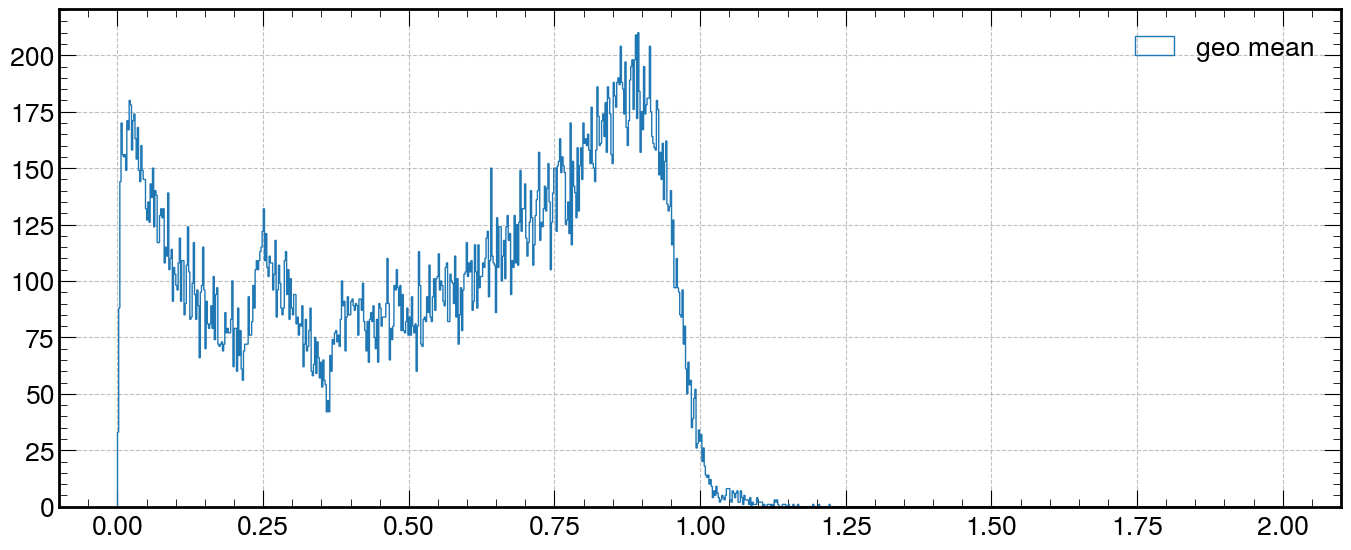

In [348]:
dftmp = mcsangle.sort(selection_events('ei')).group_by(selection_events()).agg(
    pl.col("isContained").last(),
    K = pl.col("E").first()-0.1057,
    Elost = pl.col("Elost").last(),# - pl.col('Ei').last(),
    nsteps = pl.col('ei').len(),
    ei = pl.col('ei').first(),
).with_columns(
    diff = ((pl.col("Elost"))/(pl.col('K'))),
# ).filter(pl.col("isContained")
# ).filter(
#     pl.col('ei') < 30
)
plt.hist(dftmp['diff'], bins=np.linspace(0.,2,1000), histtype='step', label='geo mean');
plt.legend()
# plt.xscale('log')
# mcsangle = mcsangle.join(dftmp.select(selection_events(['diff','nsteps'])), on=selection_events())

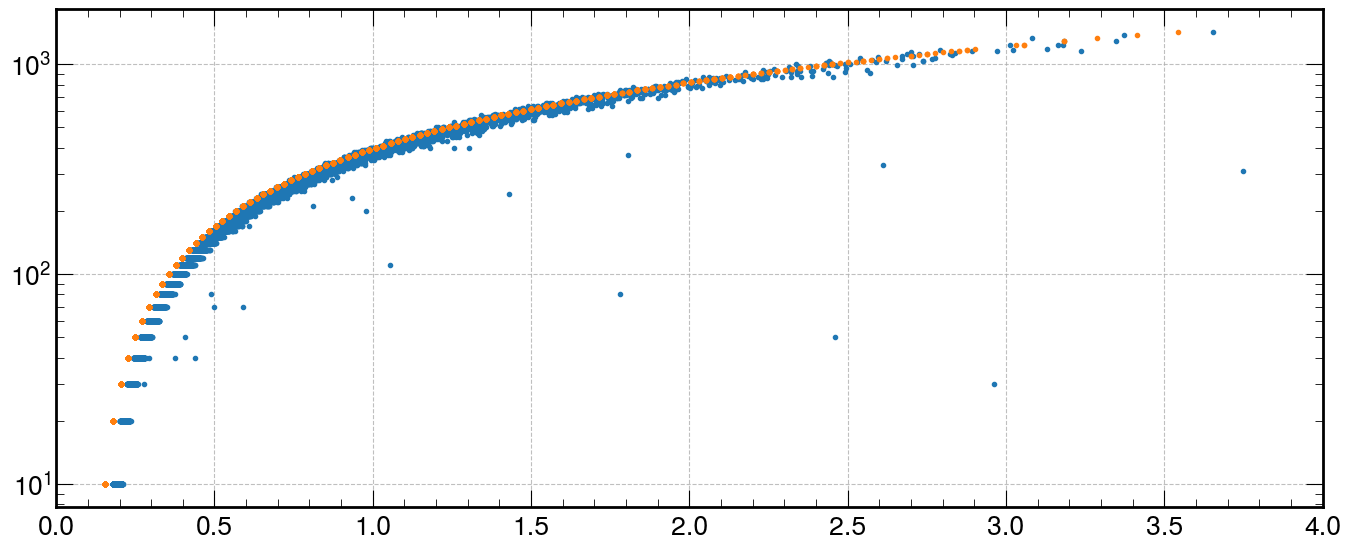

In [349]:
len_cm = np.array([9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
          3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
          2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
          1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])/1.396
 
KE_GeV = np.array([10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
          4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
          200000, 300000, 400000])/1e3
from scipy.interpolate import CubicSpline
KE_by_len = CubicSpline(len_cm,KE_GeV)
tmp = mcsangle.group_by(selection_events()).agg(
    pl.col('E').first(),
    pl.col('isContained').first(),
    pl.len()*10,
).filter(pl.col('isContained')).with_columns(
    Erange = pl.col('len').map_elements(lambda x: KE_by_len(x), return_dtype=pl.Float32) + 0.1057
)
plt.plot(tmp['E'],tmp['len'],'.')
plt.plot(tmp['Erange'],tmp['len'],'.')
plt.xlim(0,4)
# plt.xscale('log')
plt.yscale('log')

In [350]:
# mcsangle.group_by(selection_events()).agg(
#         Einf = pl.col("Ei").filter((pl.col("Ei").is_infinite())).count(),
#         Ei = pl.col("Ei").count(),
#         p = pl.col("p").first(),
#         pdg = pl.col('trkpdg').first(),
#         isContained = pl.col('isContained').first(),
#         # pl.col("Ei"),
#         # pl.col('ei'),
#     ).filter(pl.col('Einf')>0).sort(selection_events())
# mcsangle

/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/tmp/ipykernel_100125/1269561361.py:52: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))


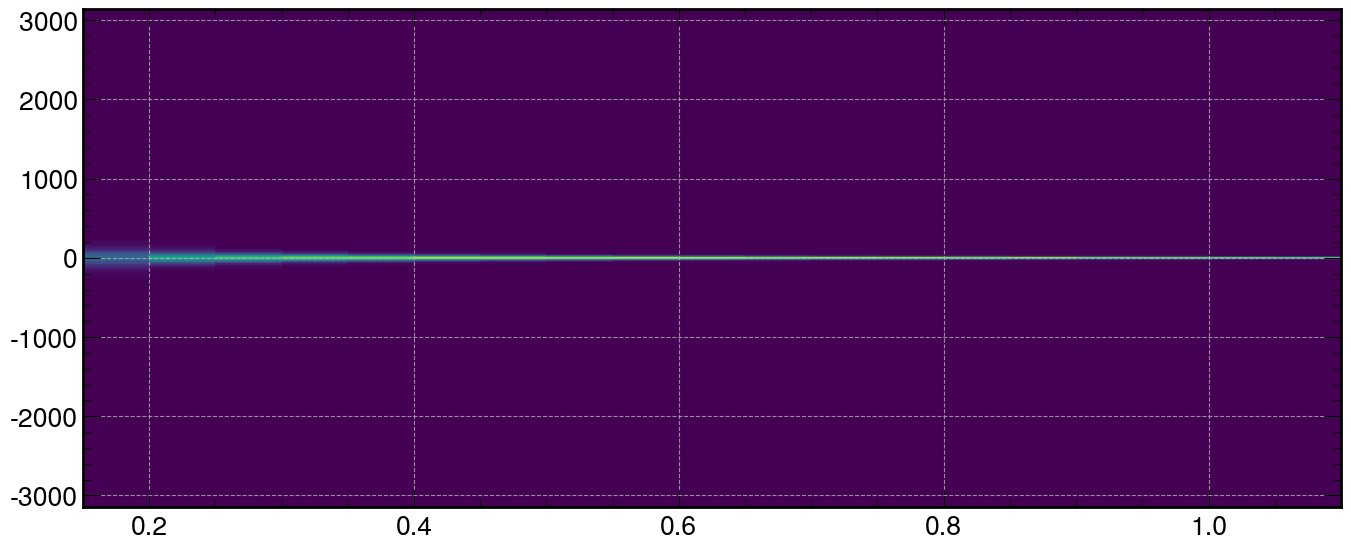

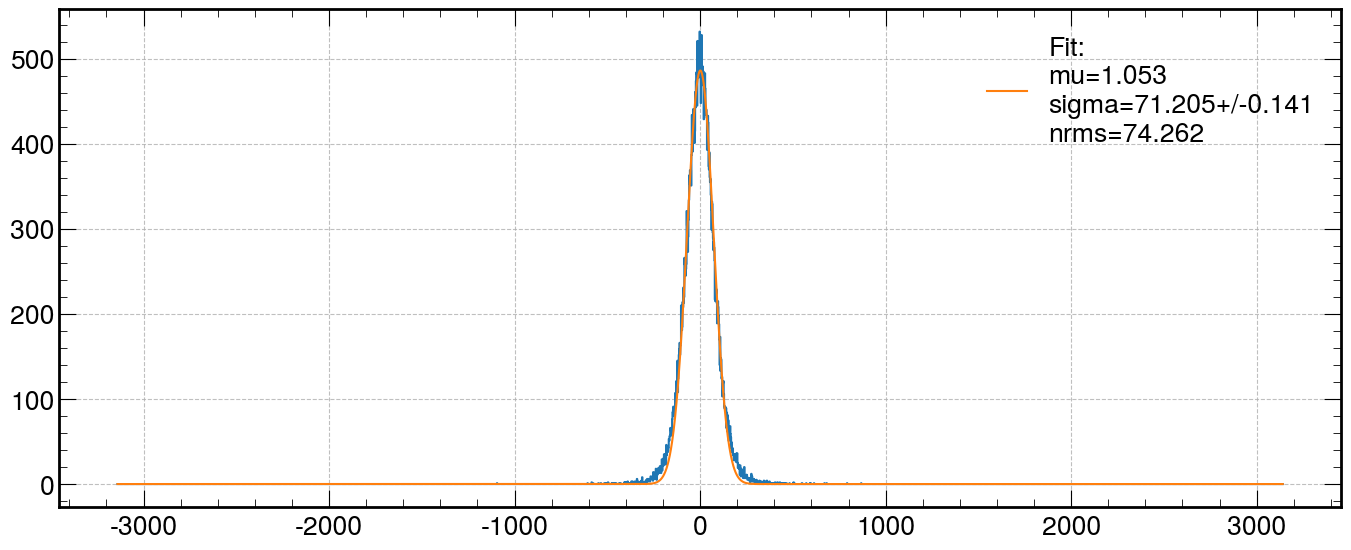

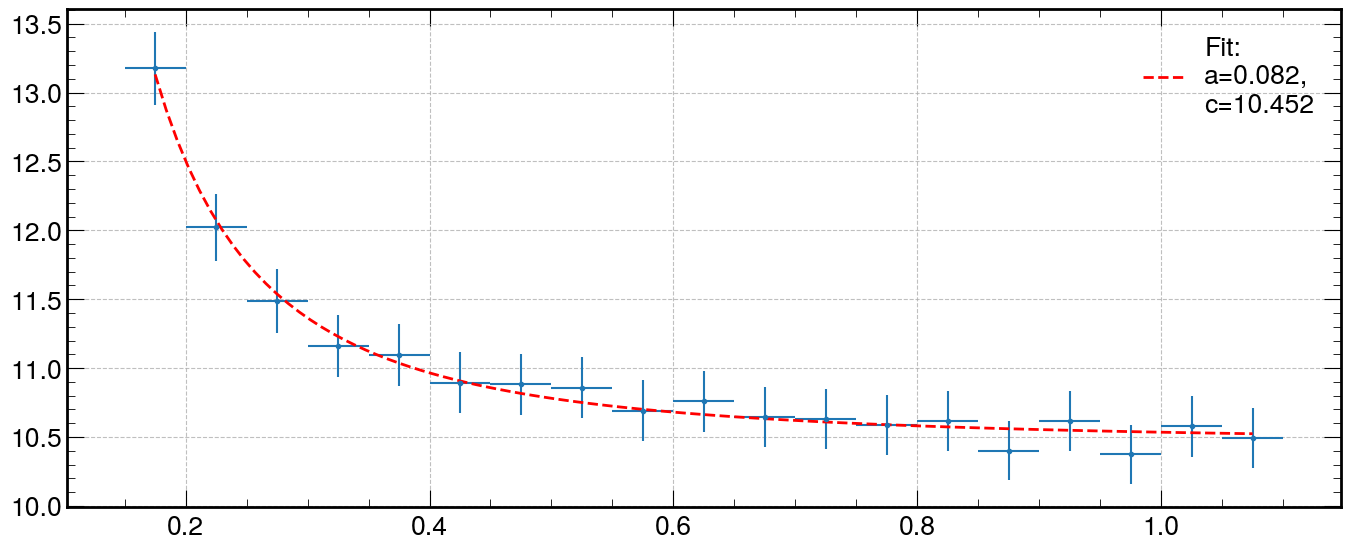

In [351]:
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

def fit_s2(x, a, c):
    return (a/x**2+c)

def compute_s2(p, rms):
    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    beta = np.sqrt(1 - ((m_muon*m_muon)/(p*p + m_muon*m_muon)))
    const =  (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return p*beta*rms/const

def compute_s2_err(p, rms, erp_percent, errms):
    s2 = compute_s2(p, rms)
    return s2*np.sqrt(erp_percent**2 + errms**2/rms**2)

    

def cut_rms(data:np.ndarray, cut=2.7, repeat=5) -> float:
    rms = 0
    for _ in range(repeat):
        rms = np.std(data)
        data = data[abs(data) < cut*rms]
    rms = np.std(data)
    return rms

variable='Ei'

dfc = mcsangle.filter(
    pl.col('ei') != -1,
    # pl.col('nsteps') > 2,
    pl.col('avalid'),
    pl.col('len')>30,
)
# binsx = np.logspace(np.log10(0.15),np.log10(1.5),50)
binsx = np.linspace(0.15,1.1,20)
rms, _, _ = binned_statistic(np.sqrt(dfc[variable]**2-0.1057**2), dfc['azx'], cut_rms, binsx)
count, _, _ = binned_statistic(np.sqrt(dfc[variable]**2-0.1057**2), dfc['azx'], "count", binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
hh, hxe, hye, _ = plt.hist2d(np.sqrt(dfc[variable]**2-0.1057**2), dfc['azx'], bins=[binsx, np.linspace(-3141.5,3141.5,3141)] );


aux = 0
plt.figure()
hycenters = (hye[:-1] + hye[1:])*0.5
plt.step(hycenters, hh[aux])
popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))
perr = np.sqrt(np.diag(pcov))
plt.plot(hycenters, gaus(hycenters, *popt), label = f"Fit:\nmu={popt[0]:5.3f}\nsigma={popt[1]:5.3f}+/-{perr[1]:5.3f}\nnrms={rms[aux]:5.3f}")
plt.legend()


plt.figure()
nanrms = rms[~np.isnan(rms)]
errms = nanrms/np.sqrt(2*(count[~np.isnan(rms)]-1))
nancenters = bins_center[~np.isnan(rms)]
nancount = count[~np.isnan(rms)]
ercenter = np.zeros_like(nancenters)
ercenter = (binsx[1:] - binsx[:-1])*0.5

# nancenters = (hxe[:-1] + hxe[1:])*0.5
# ercenter = (binsx[1:] - binsx[:-1])*0.5
# nanrms = []
# nancount = []
# errms = []
# for v, c in zip(hh, count):
#     popt, pcov = curve_fit(gaus,hycenters, v,p0=[0,20,20], sigma=1/np.sqrt(v))
#     nanrms.append(abs(popt[1]))
#     perr = np.sqrt(np.diag(pcov))
#     _errms = np.sqrt(perr[1]**2 + popt[1]**2/(2*c-2))
#     errms.append(_errms)
    
s2 = compute_s2(nancenters, nanrms)
errS2 = compute_s2_err(nancenters, rms, 0.02, errms)
plt.errorbar(nancenters, s2, errS2, ercenter, '.' )
popt, pcov = curve_fit(fit_s2, nancenters, s2, p0=[0.1, 11], sigma=errS2)#np.ones_like(s2))
# plt.plot(nancenters, func(nanrms, *[0.1,11]), 'r--', label="Fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
# nancenterfit = np.logspace(np.log10(nancenters[0]), np.log10(nancenters[-1]),100)
nancenterfit = np.linspace(nancenters[0], nancenters[-1],100)
plt.plot(nancenterfit, fit_s2(nancenterfit, *popt), 'r--', label="Fit:\n" r"a=%5.3f," "\n" r"c=%5.3f" % tuple(popt), lw=2)
plt.legend()
# plt.xscale('log')


# p_s2 = nancenters
# plt.plot(nancenterfit, np.interp(nancenterfit, p_s2, s2))




/tmp/ipykernel_100125/1093493876.py:17: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus, hc, hh, p0=[0,10,500], sigma=1/np.sqrt(hh))
/tmp/ipykernel_100125/1093493876.py:22: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus, hc, hh, p0=[0,10,500], sigma=1/np.sqrt(hh))


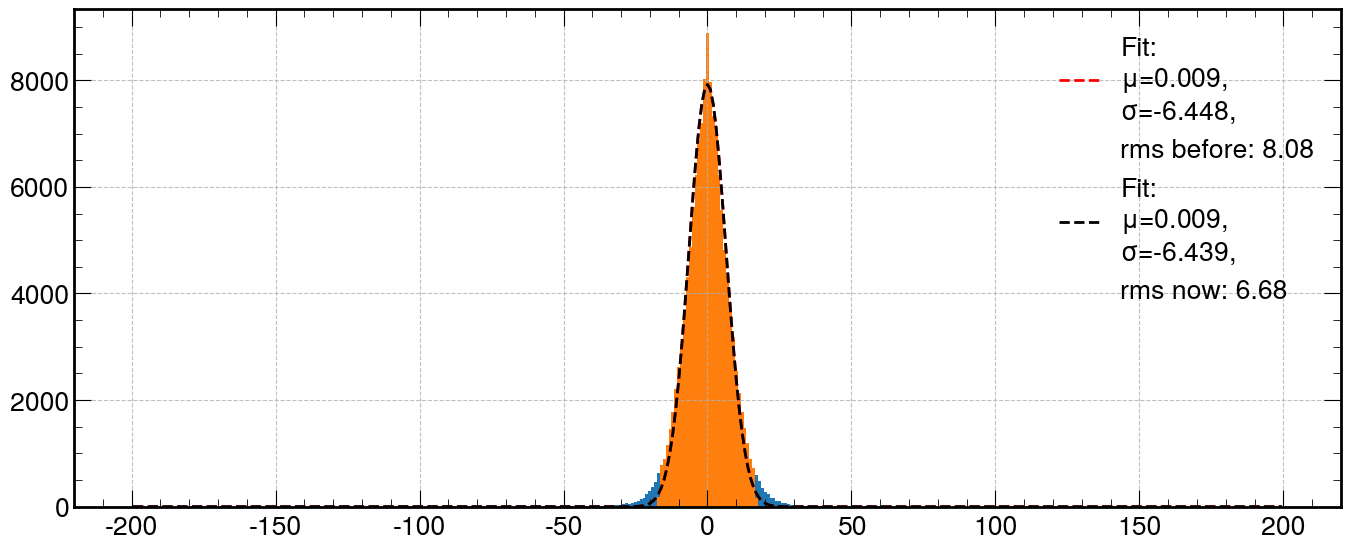

In [352]:
dftmp = mcsangle.filter(
    pl.col("Ei").is_between(1,1.5)
)
def cut_by_rms(df:pl.DataFrame, cut=2.5, repeat=1):
    rms = []
    values = df['azx'].to_numpy()
    for _ in range(repeat):
        rms.append(np.std(values))
        values = values[abs(values) < cut*rms[-1]]
    rms.append(np.std(values))
    return values, rms
dftmp2, rms2 = cut_by_rms(dftmp,2.5, repeat=4)
rms = rms2[0]

hh, he, _ = plt.hist(dftmp['azx'], bins=np.linspace(-200,200,400));
hc = (he[1:]+he[:-1])*0.5
popt, pcov = curve_fit(gaus, hc, hh, p0=[0,10,500], sigma=1/np.sqrt(hh))
plt.plot(hc, gaus(hc, *popt), 'r--', label="Fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
plt.plot([],[], ' ', label=f"rms before: {rms:.2f}", c='k')

hh, he, _ = plt.hist(dftmp2, bins=np.linspace(-200,200,400));
popt, pcov = curve_fit(gaus, hc, hh, p0=[0,10,500], sigma=1/np.sqrt(hh))
plt.plot(hc, gaus(hc, *popt), 'k--', label="Fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
plt.plot([],[], ' ', label=f"rms now: {rms2[-1]:.2f}", c='k')
plt.legend()


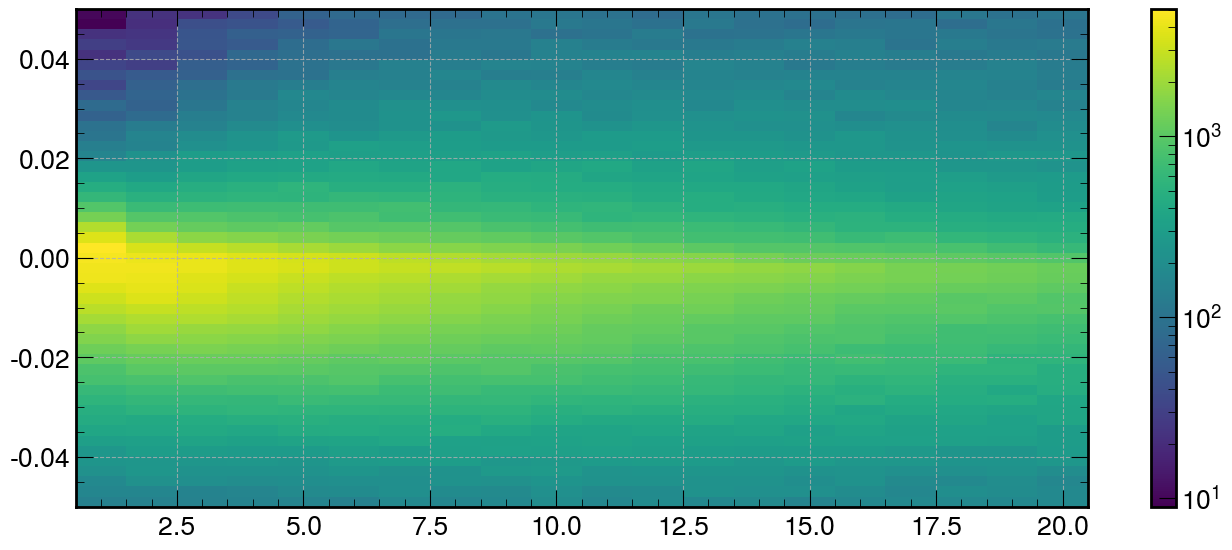

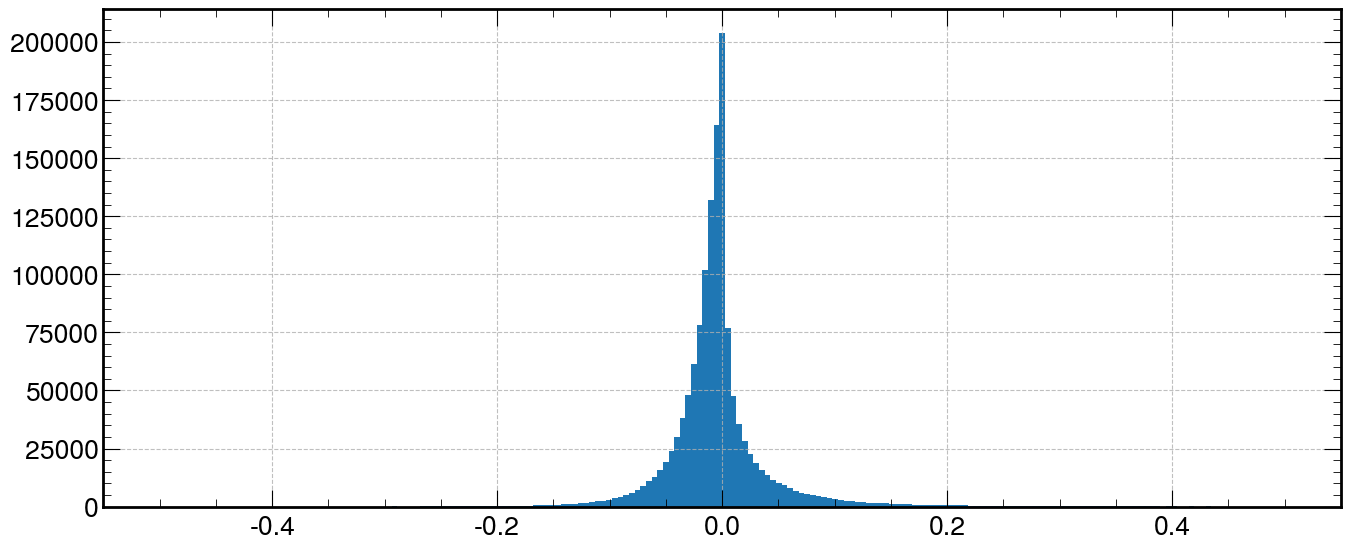

In [353]:
dfeidiff = mcsangle.with_columns(
    Eidiff = pl.col("Ei")/pl.col("Ei_true")-1
)

dfenddiff = dfeidiff.group_by(selection_events('ei'), maintain_order=True).agg(
    pl.col('Eidiff').last()
)

plt.hist2d(dfeidiff['ei']/10, dfeidiff['Eidiff'], bins=[np.linspace(0.5,20.5,21), np.linspace(-0.05,0.05,50)], norm='log');
plt.colorbar()
plt.figure()
plt.hist(dfenddiff['Eidiff'], bins=np.linspace(-0.5,0.5,200));
# plt.yscale('log')


1.1219758071002783

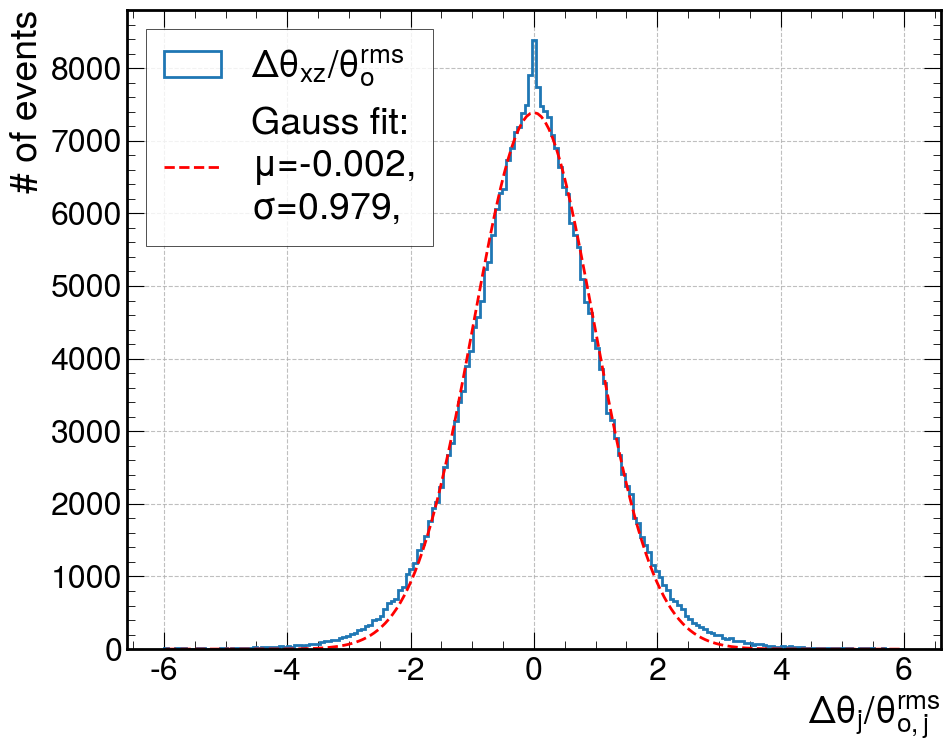

In [354]:
def compute_rms(p=None, _ei=None):
    if p is None: 
        p = pl.col('p')
    if _ei is None: 
        # _ei = pl.col('ei'root)
        _ei = pl.col('Ei')
    
    a = 0.079
    c = 10.435

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Etot = np.sqrt(p*p + m_muon*m_muon)
    # nonrel_Eij = nonrel_Etot - _ei*0.0021
    nonrel_Eij = _ei

    nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
    beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
    tH0 = ( (a/nonrel_pij**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return tH0

mcsangle = mcsangle.with_columns(
    rms = ( compute_rms()**2 + 0**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
)

df = mcsangle
dfplot = df#.filter(pl.col("E")<1)#.filter((pl.col('azx')/pl.col('rms')).abs()>0.0007)
dfplot = df.filter(
    (pl.col('azx')).abs()>-1
).filter(
    pl.col("isContained") == True
# ).filter(
#     (pl.col('E')-0.1057)/pl.col("Elost")>2
)

dfplotnotend = dfplot.group_by(selection_events()).agg(
    pl.col('ei').head(pl.col('ei').len())
    # pl.col('ei').head(3)
).filter(
    pl.col('ei').len()>0
).explode('ei')
dfplot = dfplot.join(dfplotnotend, on=selection_events('ei'))
plt.figure(figsize=(10,8))
binsx = np.linspace(-6,6,200)
# heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms'])*np.sqrt(2), bins=binsx, histtype='step', label=r'$\sqrt{2} \times \Delta\theta_{xz}/\theta^{rms}_o$',lw=2,color='k');
heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms']), bins=binsx, histtype='step', label=r'$\Delta\theta_{xz}/\theta^{rms}_o$',lw=2);
hcenters = (hedges[1:] + hedges[:-1])*0.5
# cfitlim = abs(hcenters)<1.5
# hcenters = hcenters[cfitlim]
# heigths = heigths[cfitlim]
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,35000])#, sigma=1/np.sqrt(heigths))
perr = np.sqrt(np.diag(pcov))
# popt[1] = popt[1]/np.sqrt(2)
plt.plot(hcenters, gaus(hcenters, *popt), 'r--', label="Gauss fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
plt.tick_params(labelsize=23)
plt.xlabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.ylabel('# of events', fontsize=27)
# plt.yscale('log')
legend = plt.legend(frameon=True, fontsize=27, fancybox=False, loc='upper left')
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_linewidth(0.6)
(dfplot['azx']/dfplot['rms']).drop_nans().std()


In [355]:
# Example bad reconstruction, 70,1 is a muons escaping, llhd and range give same result
dfsmalls = dfplot.group_by(selection_events()).agg(
    azx_total = pl.len(),
    azx_small = pl.col('azx').filter((pl.col('azx')/pl.col('rms')).abs()<0.07).count(),
    len = pl.col('len') .first(),
    E = pl.col('E').first()
).with_columns(
    frac = pl.col('azx_small')/pl.col('azx_total')
).filter(pl.col("azx_small")>0)
# df
dfsmalls.describe()

statistic,run,subrun,event,azx_total,azx_small,len,E,frac
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",9951.0,9951.0,9951.0,9951.0,9951.0,9951.0,9951.0,9951.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.7878e7,1.0,48897.945232,21.74284,1.847151,232.481473,0.648607,0.130177
"""std""",2.9082e7,0.0,30626.367743,17.807906,1.404605,178.108868,0.405433,0.128673
"""min""",6.411871e6,1.0,3.0,1.0,1.0,20.119913,0.178973,0.012195
"""25%""",6.456061e6,1.0,23295.0,9.0,1.0,105.697332,0.36828,0.060606
"""50%""",5.0579427e7,1.0,47211.0,17.0,1.0,181.579641,0.529423,0.095238
"""75%""",6.6049673e7,1.0,70379.0,29.0,2.0,305.887051,0.802746,0.15
"""max""",7.458143e7,1.0,119995.0,143.0,20.0,1448.652128,3.748328,1.0


/home/henrique/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/henrique/.local/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/henrique/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 1, '# of events')

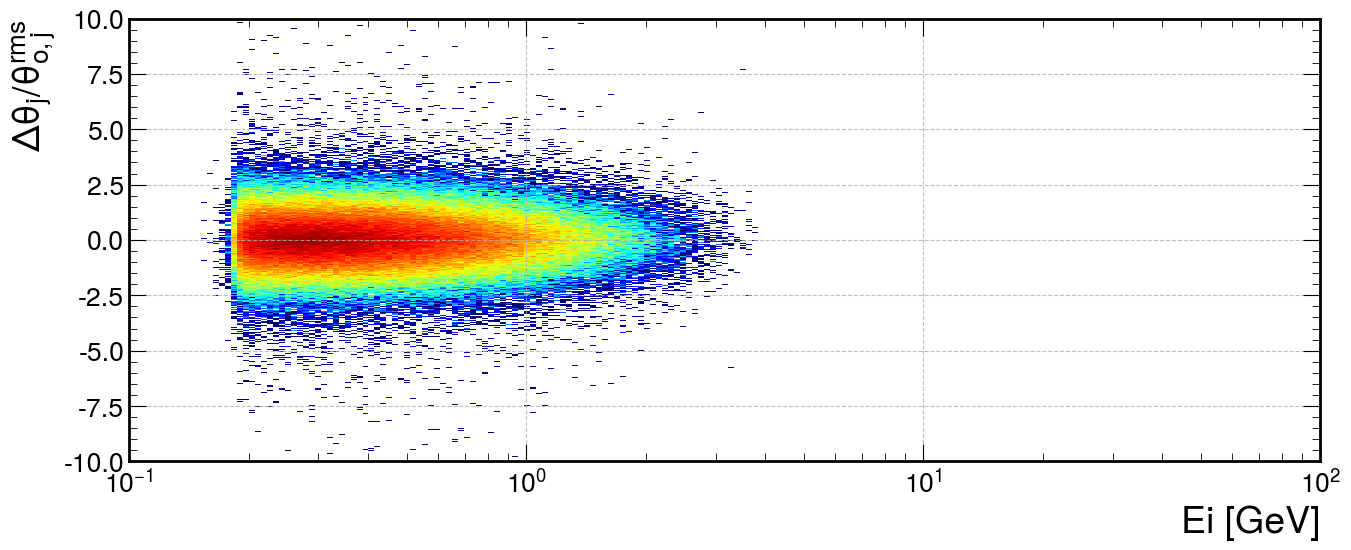

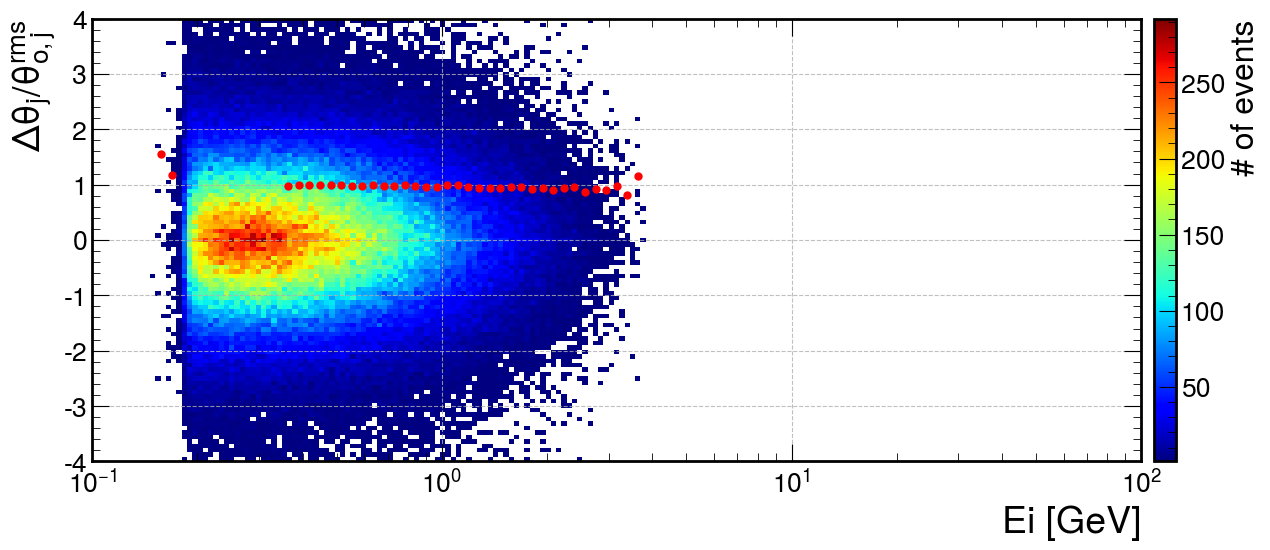

In [356]:

plt.hist2d(dfplot['Ei_true'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-10,10,500)],cmap=plt.cm.jet, norm='log', label='Some');
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.xscale('log')

plt.figure()
binsx = np.logspace(-1,2,100)
val, _, _ = binned_statistic(dfplot['Ei_true'], dfplot['azx']/dfplot['rms'], cut_rms, binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
plt.hist2d(dfplot['Ei_true'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-4,4,100)], cmap=plt.cm.jet, cmin=1)
lines = plt.plot(bins_center, val, 'o', markersize=5, color='r',)
# plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-10,10,100)], cmap=plt.cm.jet, cmin=1)
# fakeE = np.logspace(-1,2,200)
# fakeEi = np.zeros_like(fakeE)
# fakeRMS = compute_rms(fakeE, fakeEi)
# plt.plot(fakeE,fakeRMS, '--', color='red', lw=2)
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
# plt.ylabel(r'$\Delta\theta_{zx}$', fontsize=27)
plt.xscale('log')
cbar = plt.colorbar(pad=0.01)
cbar.ax.set_ylabel('# of events', fontsize=23)
# dfplot.filter(get_event(70,1))
# anatree.nu.filter(get_event(70,1))["RecoLepEnNumu_mcs_llhd"]

In [357]:
# pl.Config.set_tbl_rows(40)
# dfout.group_by(selection_events()).agg(
#     pl.count(),# plot_res_vs_energy(dftemp['E'],
#                    dftemp['RecoLepEnNumu_range'],
#                    label=r'CSDA')
#     pl.all(),
# ).explode(pl.all().exclude(selection_events(['count']))).sort('subrun').sort('count', descending=True).head(40)

dfllhd = df.group_by(selection_events()).agg(
    pl.all().exclude('seg','len','p', 'isContained'),
    len = pl.col('len').first(),
    p = pl.col('p').first(),
    isContained = pl.col('isContained').first(),
    nvalids = pl.col('avalid').filter(pl.col('avalid')==True).len(),
).sort(selection_events())
vals = dfllhd.select(['theta', 'ei', 'p', 'subrun', 'event', 'azx', 'azy','len', 'avalid', 'run', 'isContained', 'Ei', 'lenseg']).to_numpy()
thetas = vals[:,0]
ei = vals[:,1]
trueP = vals[:,2]
srun = vals[:,3]
evt = vals[:,4]
azx = vals[:,5]
azy = vals[:,6]
trklen = vals[:,7]
avalid = vals[:,8]
run = vals[:,9]
isContained = vals[:,10]
Ei = vals[:,11]
seglen = vals[:,12]



    

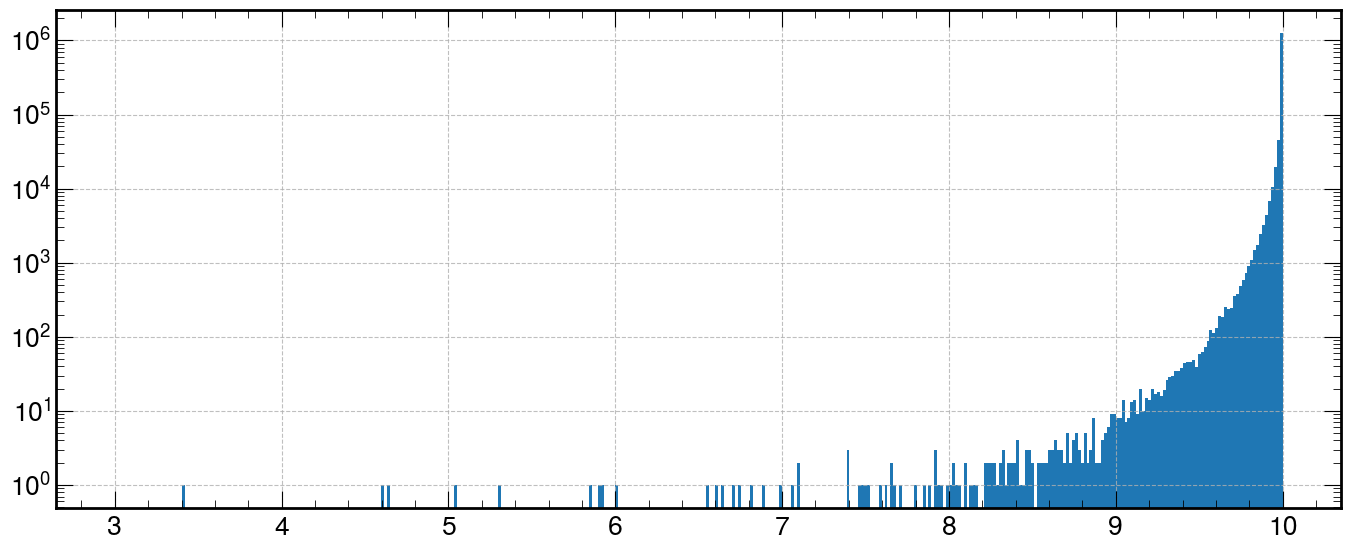

In [319]:
plt.hist(np.cos(df['theta']/1000)*10, np.linspace(3,10,400));
plt.yscale('log')

In [320]:
import numba as nb
@nb.njit
def llhd(evDT, evValid, correct, p, res):
    def S2(p):
        # a = 0.1049
        # c = 11.0038
        a = 0.079
        c = 10.435
        return a/p**2 + c
        # return np.interp(p, p_s2,s2)

    rad_length = 14.0
    stepsize = 10
    m_muon = 0.1057
    Etot = np.sqrt(p*p + m_muon*m_muon)

    result = 0
    dei = 0
    penality = False
    Eij = Etot
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        Eij = Eij - dei
        if Eij>= E_GeV[0]:
            dei = np.interp(Eij, E_GeV, dEdx)*stepsize
        else:
            dei = dEdx[0]*stepsize
        if Eij <= m_muon:
            penality=True
            Eij = m_muon+0.01
        # if nonrel_Eij < m_muon:
        #     return 99999

        red_length = stepsize / rad_length
        pij = np.sqrt(Eij*Eij - m_muon*m_muon)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(pij*pij + m_muon*m_muon)))
        tH0 = ( S2(pij) / (pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
        if correct:
            tH0 *= np.sqrt(2)
        rms_square = (tH0**2 + res**2)
        # if evValid[idx] is False:
        #     continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms_square) - 0.5*dth*dth/rms_square
        if penality:
            prob -= 2*rms_square
        result-=2*prob
    return result
def call_llhd(p:float, res:float, ev:int):
    global DT
    global Valid
    global correct
    
    ev = int(ev)
    result = 0
    result = llhd(DT[ev], Valid[ev], correct, p, res)
    return result


idx: 0, run: 6411871,  subrun: 1, event: 3103, p = 0.95, contained = True


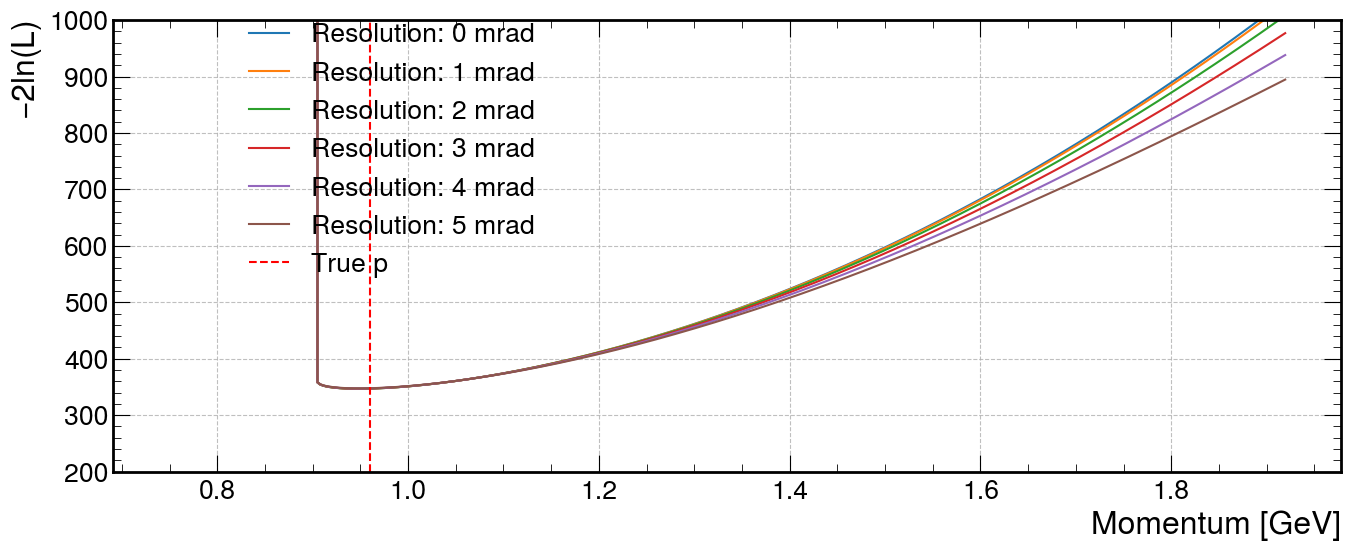

In [359]:
res_scan = [ r for r in range(0,6,1)]
res = [[] for _ in res_scan]
ptry = [[] for _ in res]
idx=0
DT = thetas#[idx]/np.sqrt(2)
Valid = avalid
correct = True
# DT = azy[idx]
for r,i in enumerate(res_scan):
    Erange = KE_by_len(len(seglen[idx])*10) + 0.1057
    Prange = np.sqrt(Erange**2 - 0.1057**2)
    for x in np.linspace(Prange*0.8, 2*trueP[idx], 400):
        ll = call_llhd(x, r, idx)
        res[i].append(ll)
        ptry[i].append(x)
    ptry[i] = np.array(ptry[i])
    plt.plot(ptry[i], res[i], label=f"Resolution: {r:.0f} mrad")
# plt.yscale('log')
plt.ylim(200,1e3)
plt.axvline(trueP[idx], color='r', linestyle='--', label='True p')
plt.ylabel(r'$-2ln(\mathcal{L})$')
plt.xlabel('Momentum [GeV]')
axbox = plt.gca().get_position
plt.legend(loc=(0.1,0.4),ncol=1)
print(f'idx: {idx}, run: {run[idx]},  subrun: {srun[idx]}, event: {evt[idx]}, p = {ptry[0][np.argmin(res[0])]:.2f}, contained = {isContained[idx]}')

In [322]:
from iminuit import Minuit, cost
from iminuit.util import describe


def lazy_min(start=0, maxevt=None, deltatheta = None, resval = 0, fixres = True, docorrect = True):
    global trueP
    global DT
    global Valid
    global correct
    global trklen
    
    
    
    DT = deltatheta
    correct = docorrect
    
    indexes = [ i for i, _ in enumerate(trueP)]

    if maxevt == None:
        maxevt = len(trueP)
    p_ = trueP[start:maxevt]
    indexes = indexes[start:maxevt]
    
    trueE = np.zeros_like(p_)
    recoE = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pt = p_[idx]
        pars = ['p', 'res', 'ev']
        Erange = KE_by_len((len(DT[idx])+2)*10) + 0.1057
        Prange = np.sqrt(Erange**2 - 0.1057**2)
        m = Minuit(call_llhd, p=2*Prange, res=resval, ev=ev)
        m.tol = 0.01/2.
        m.fixed['ev'] = True
        m.limits['p']=(0.6*Prange,100)
        m.errors['p'] = 0.001
        m.limits['res']=(0,100)
        m.fixed['res'] = fixres
        m.strategy.strategy = 2
        m.migrad()
        vals = [m.values[par] for par in pars]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        recoE[idx] = np.sqrt(vals[0]**2 + 0.1057**2)
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    recoE = recoE.astype(float)
    return trueE, recoE , fitS


In [323]:
maxevent = None
trueE, recoE, fitS = lazy_min(0,maxevent, thetas,0,True,True)
np.all(fitS==True)
trueEc = trueE[isContained[:maxevent]==True]
recoEc = recoE[isContained[:maxevent]==True]
trueEnc = trueE[isContained[:maxevent]==False]
recoEnc = recoE[isContained[:maxevent]==False]


100%|██████████| 55842/55842 [00:18<00:00, 3078.91it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

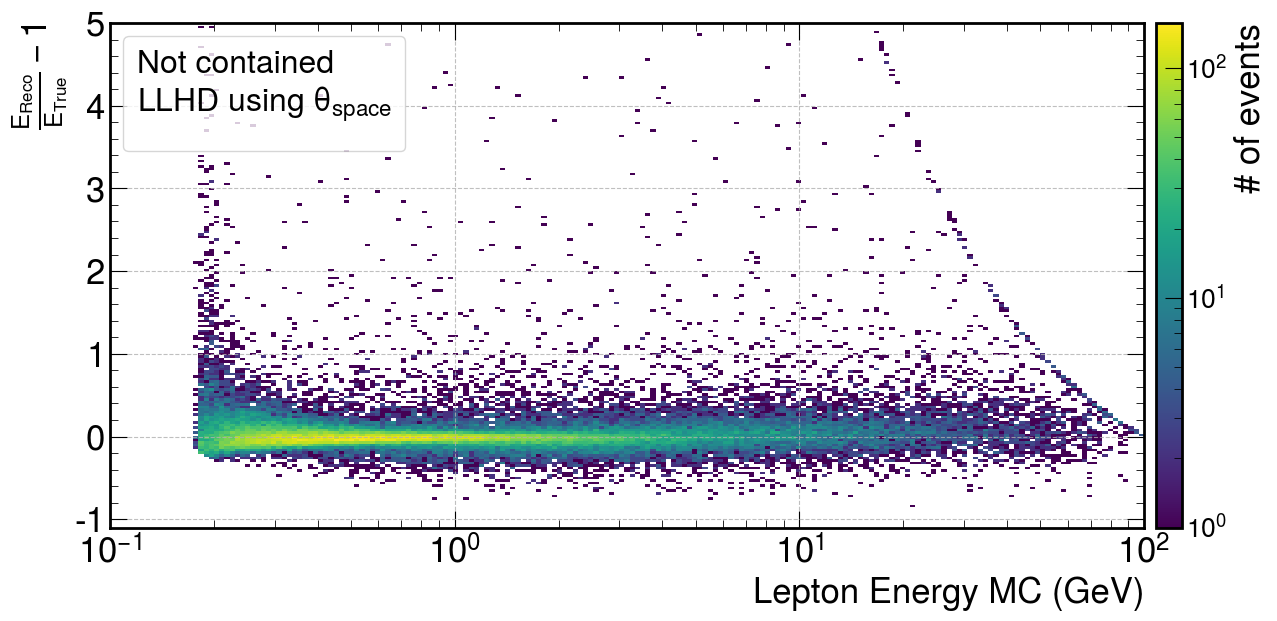

<Figure size 1400x600 with 0 Axes>

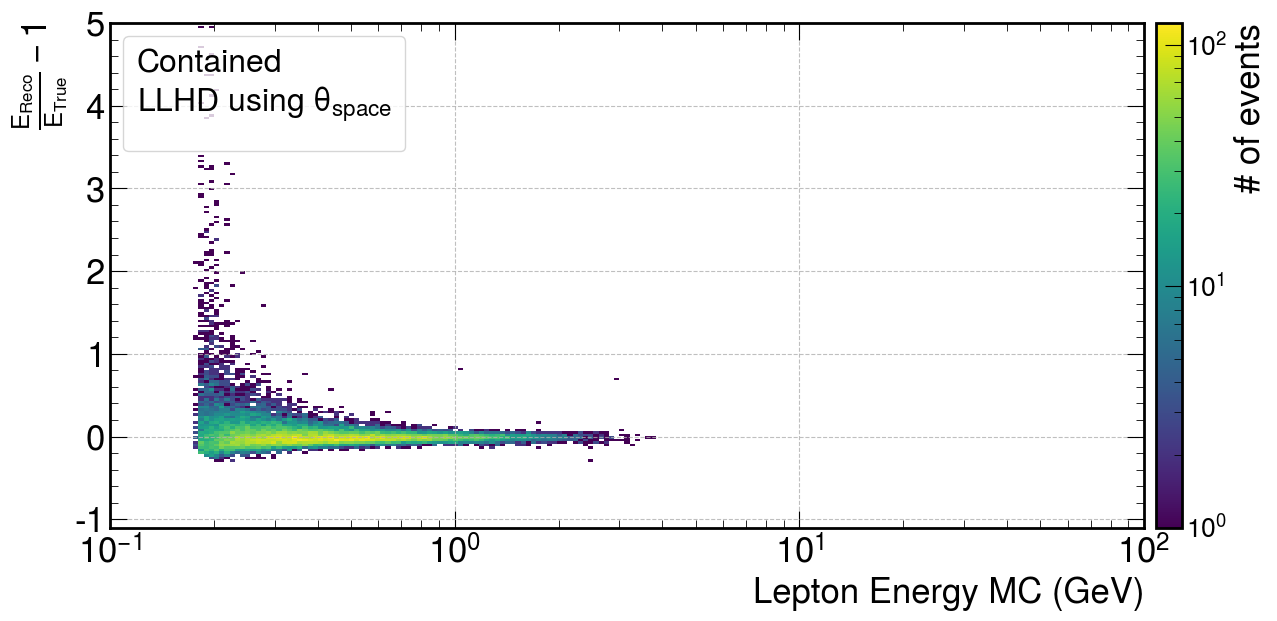

<Figure size 1400x600 with 0 Axes>

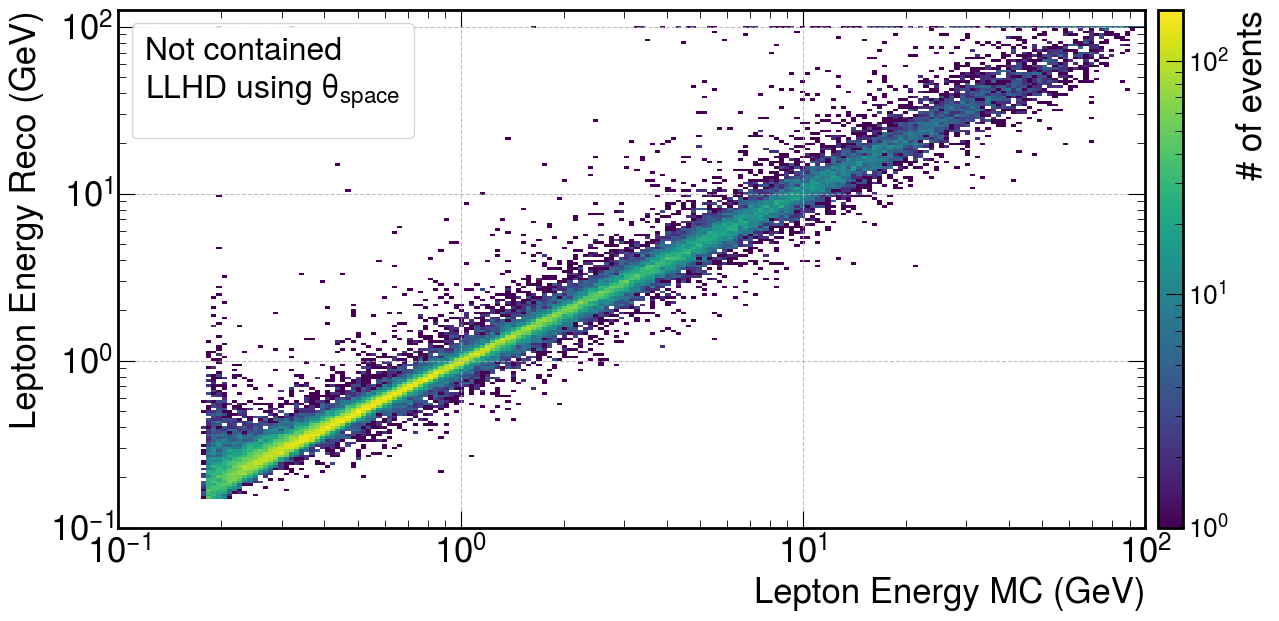

<Figure size 1400x600 with 0 Axes>

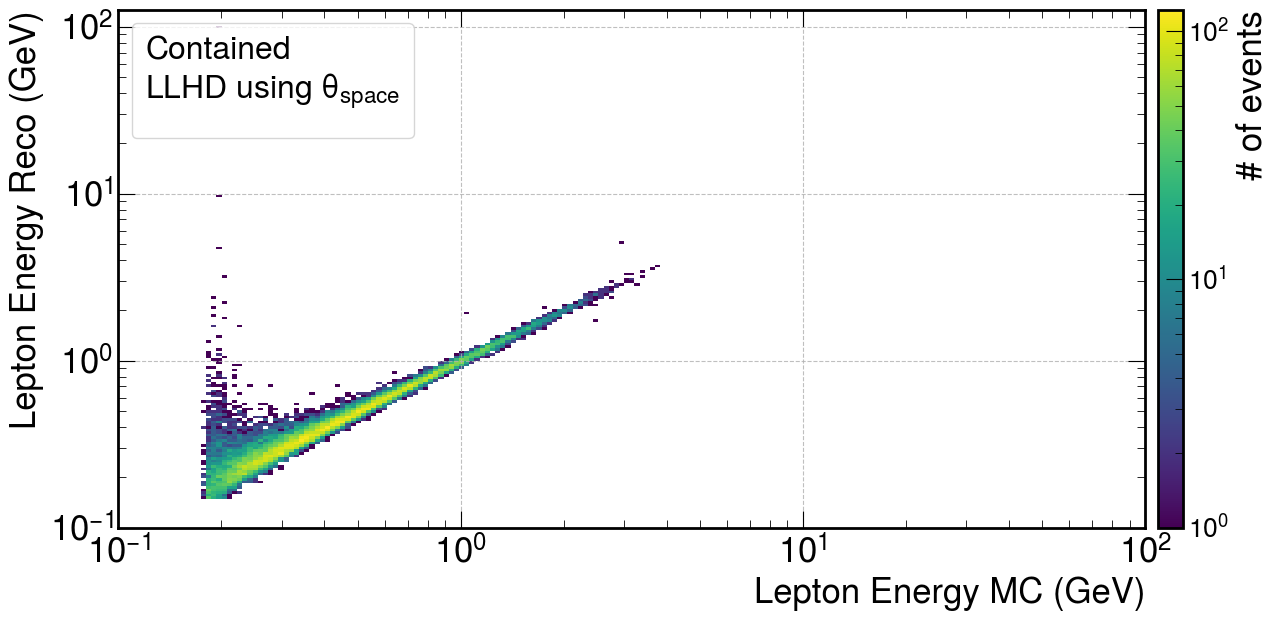

In [324]:
def display_en_reco(x,
                    y,
                    actualx = None,
                    binse = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    lmethod='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    figsize=(14,6.7)):
    plt.figure()
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    fontsize=25
    if makefrac: plt.plot([0,100],[0,100], '--', c='r')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if lmethod:
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left')
    plt.plot();
display_en_reco(trueE, recoE,
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueEc,
                recoEc,
                # actualx=recoE_nosqrt
                lmethod = r"Contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueE,
                recoE,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2.1,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueEc,
                recoEc,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2.1,200),
                yscale='log',
                lmethod = r"Contained""\n"r"LLHD using $\theta_{space}$"
                )


(0.0, 35.0)

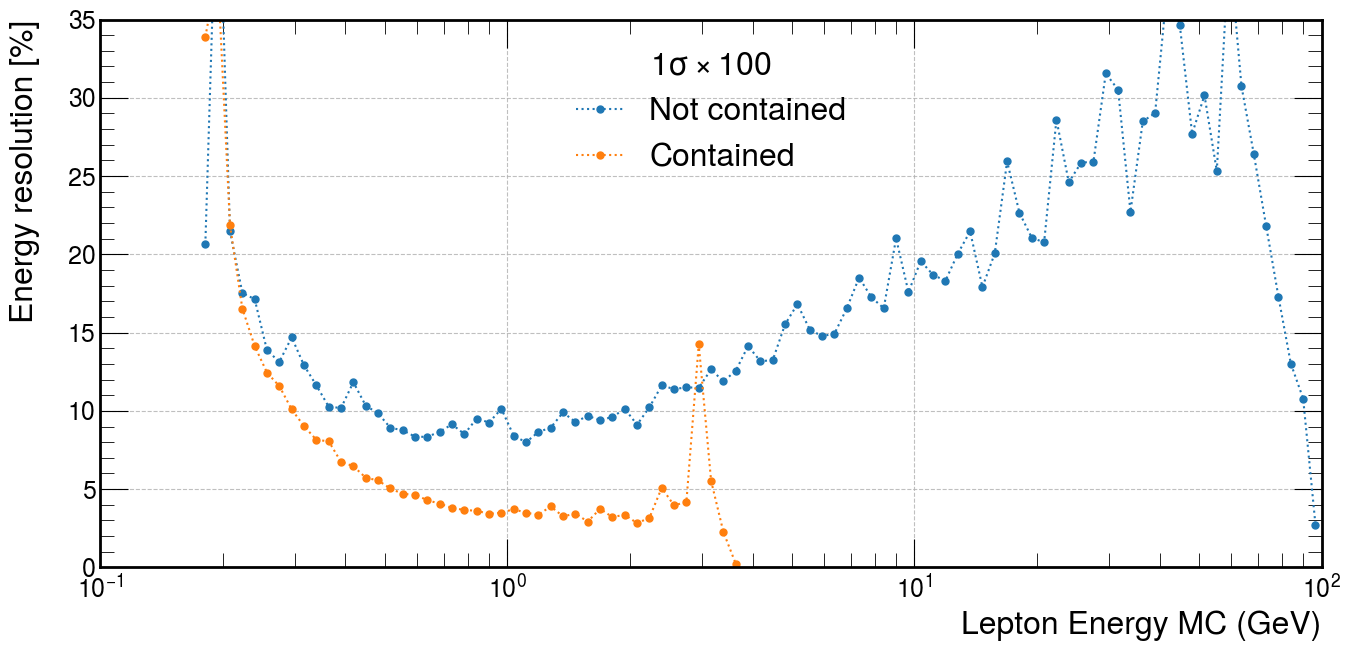

In [325]:
from scipy.stats import binned_statistic
def plot_res_vs_energy(varx, vary, actualx=None, binsx = np.logspace(-1,2,100), fmt = '.:', infotype='std', **kwargs):
    vary = (vary/varx-1)
    if not actualx is None:
        varx = [v for v in actualx]
    if infotype=='std':
        val, _, _ = binned_statistic(varx, vary*100, manual_std, binsx)
        median, _, _ = binned_statistic(varx, vary, "median", binsx)
        ylabel = r'Energy resolution [%]'
        labelpad=20
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(varx, vary, infotype, binsx)
        ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        labelpad=0
        title = 'Median'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    lines = ax.plot(bins_center, val, fmt, markersize=10, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=23, labelpad=labelpad)
    ax.set_xscale('log')
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(title=title,fontsize=23)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueEnc,
                   recoEnc,
                   label=r'Not contained')
plot_res_vs_energy(trueEc,
                   recoEc,
                   label=r'Contained')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,35)
# plt.yscale('log')
# plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

(-0.2, 0.2)

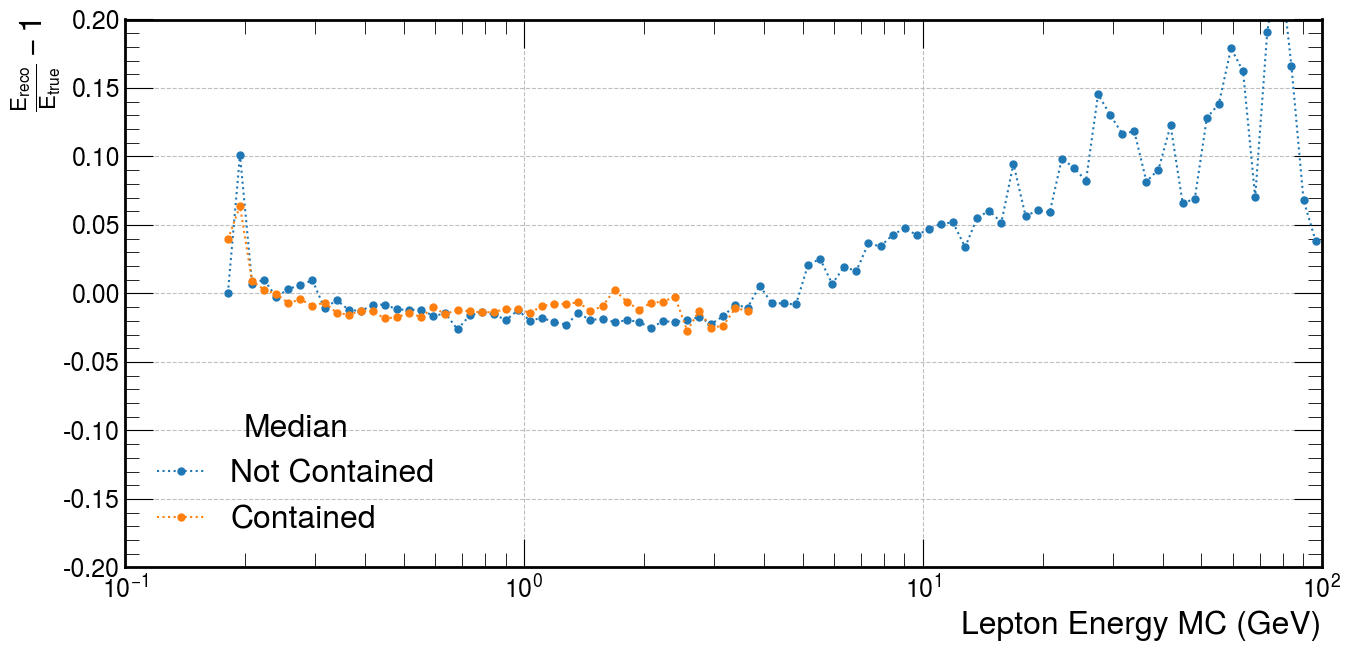

In [326]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueEnc,
                   recoEnc,
                   infotype='median',
                   label=r'Not Contained')
plot_res_vs_energy(trueEc,
                   recoEc,
                   infotype='median',
                   label=r'Contained')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-0.2,0.2)
# plt.yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

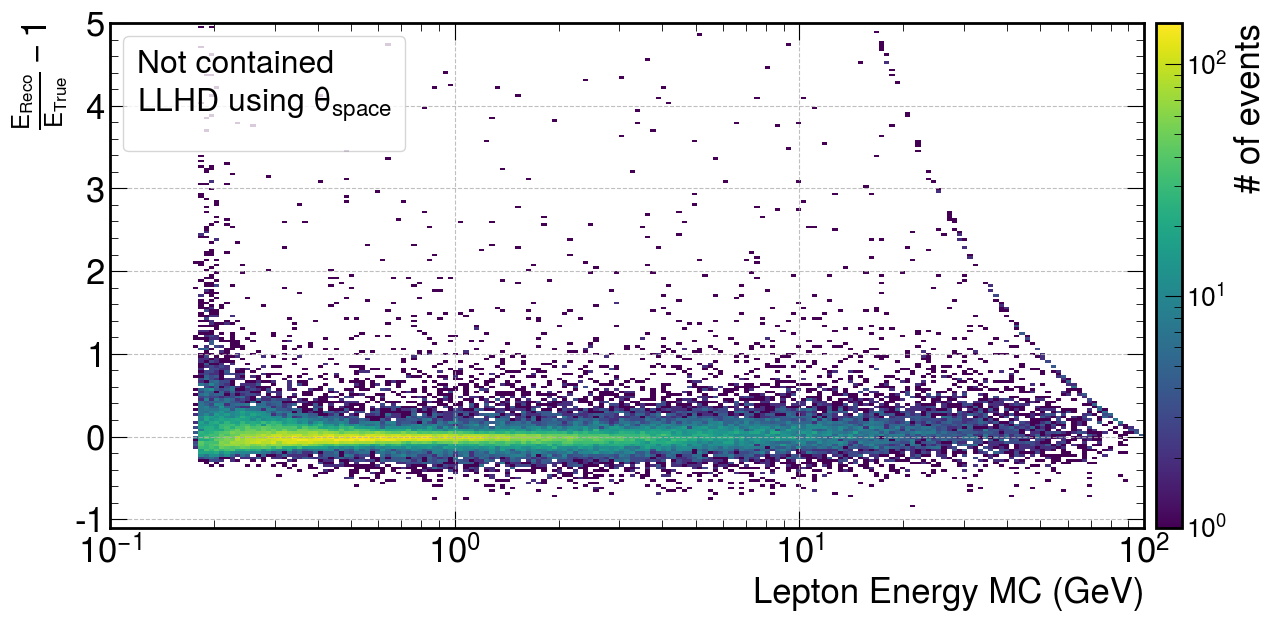

<Figure size 1400x600 with 0 Axes>

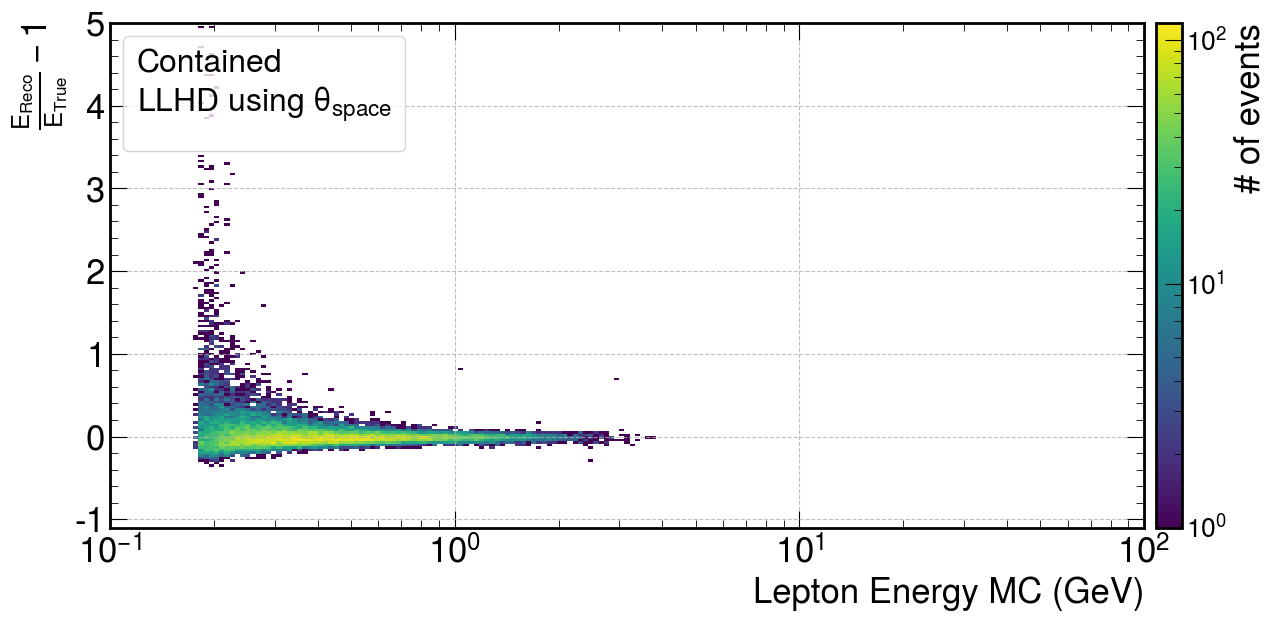

<Figure size 1400x600 with 0 Axes>

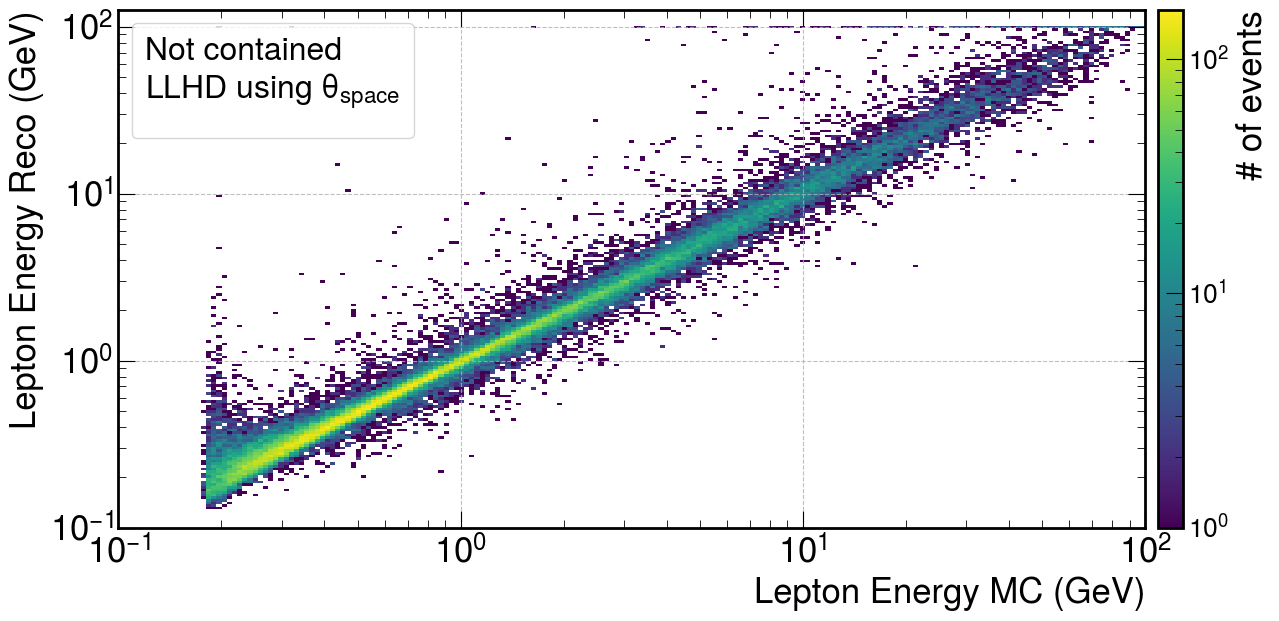

<Figure size 1400x600 with 0 Axes>

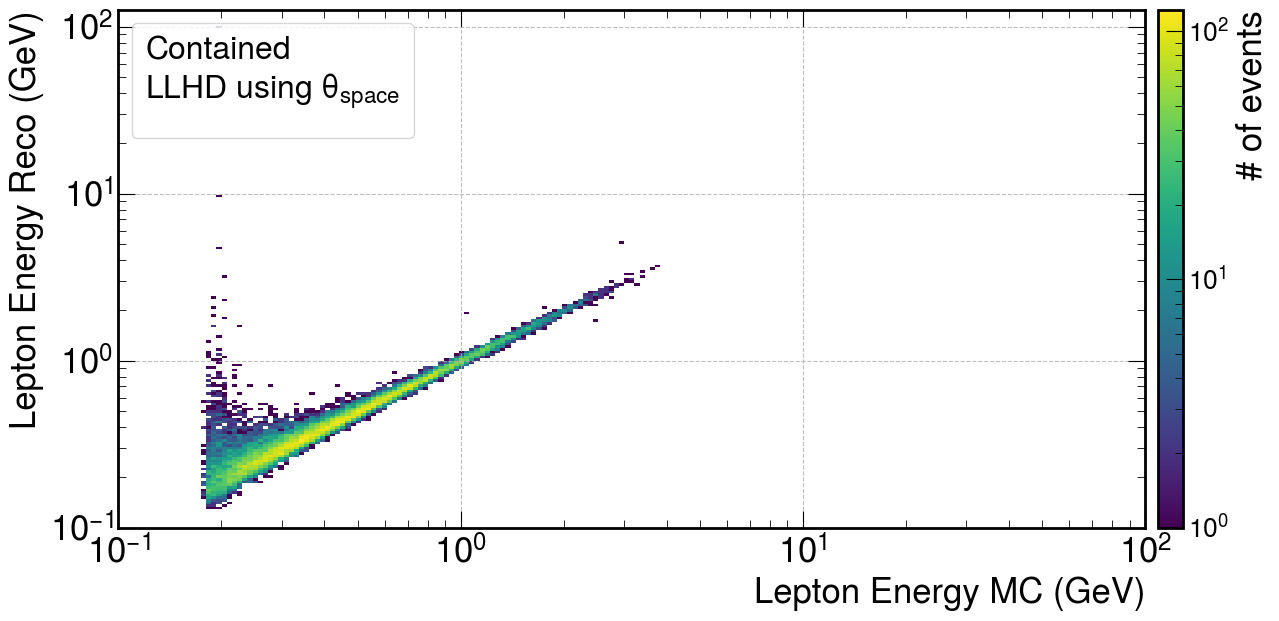

In [327]:
dfcheck = mcs.filter(
    pl.col('fitstatus')==True,
).group_by(selection_events()).agg(
    pl.all().first(),
    count = pl.col('azx').count(),
)
display_en_reco(dfcheck['E'],
                dfcheck['Ereco'],
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(dfcheck.filter(pl.col('isContained'))['E'],
                dfcheck.filter(pl.col('isContained'))['Ereco'],
                # actualx=recoE_nosqrt
                lmethod = r"Contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(dfcheck['E'],
                dfcheck['Ereco'],
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2.1,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(dfcheck.filter(pl.col('isContained'))['E'],
                dfcheck.filter(pl.col('isContained'))['Ereco'],
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2.1,200),
                yscale='log',
                lmethod = r"Contained""\n"r"LLHD using $\theta_{space}$"
                )


(0.0, 35.0)

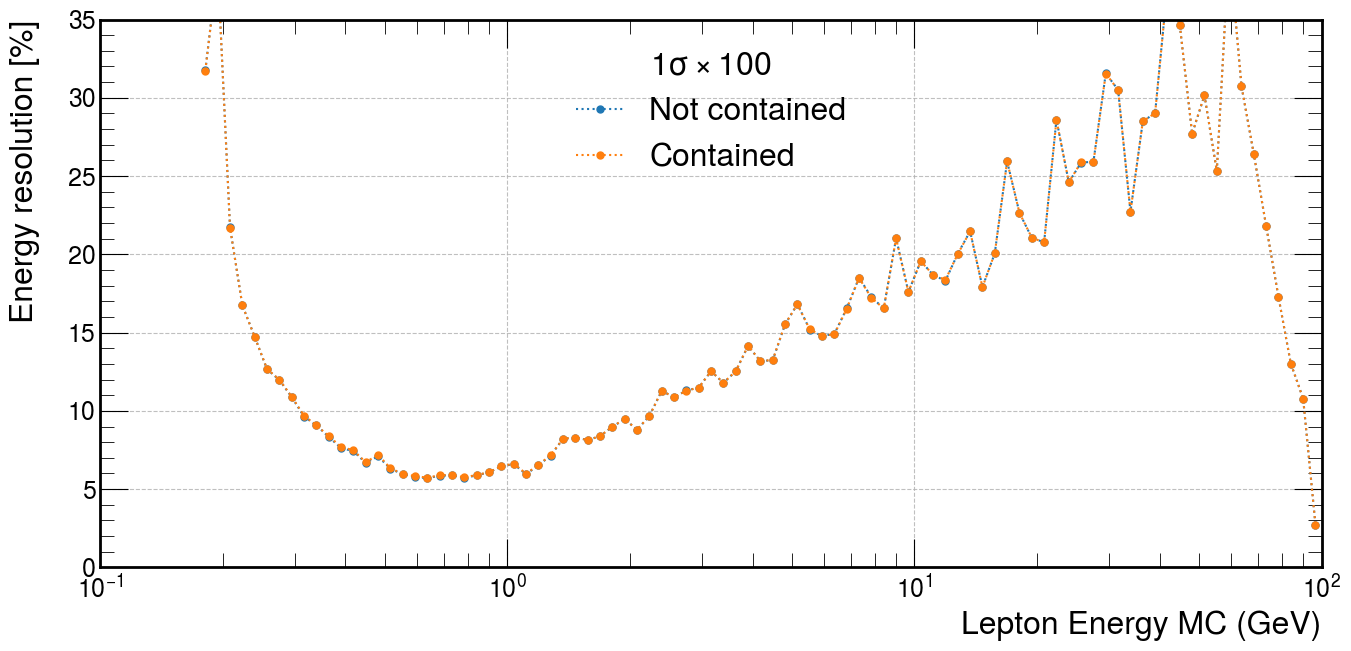

In [328]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   label=r'Not contained')
plot_res_vs_energy(dfcheck['E'],
                   dfcheck['Ereco'],
                   label=r'Contained')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,35)

(-0.2, 0.2)

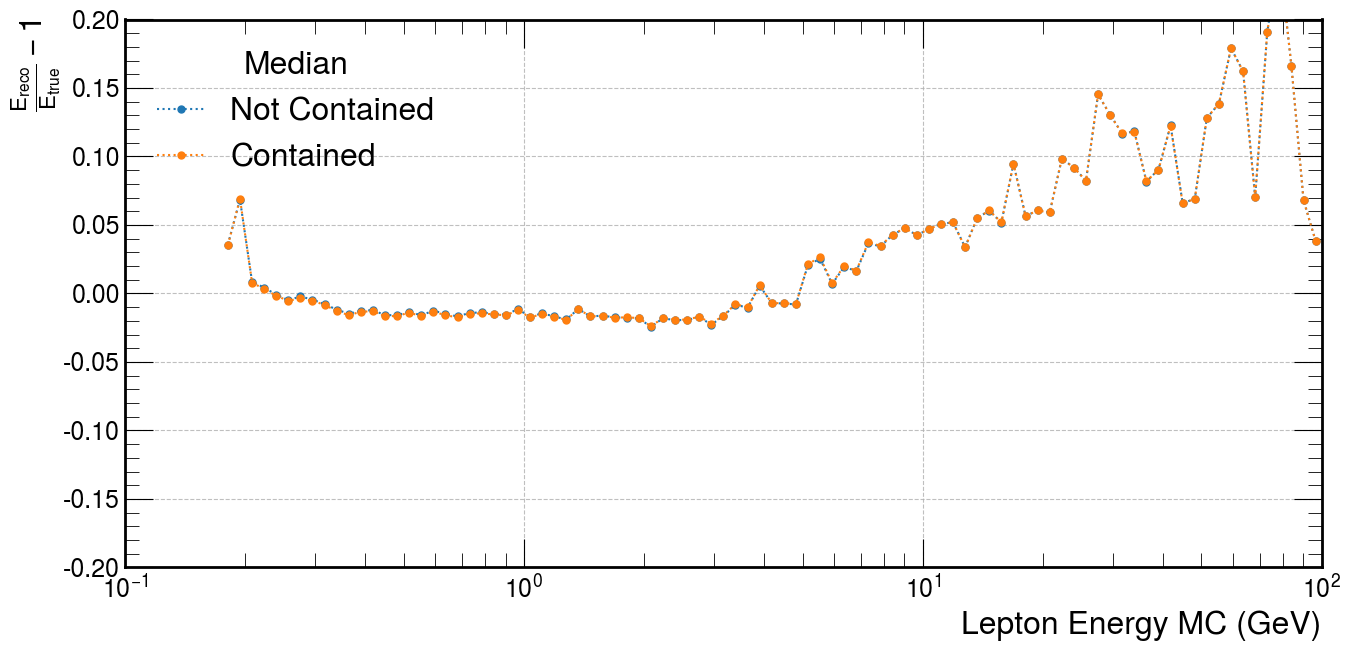

In [329]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                   label=r'Not Contained')
plot_res_vs_energy(dfcheck['E'],
                   dfcheck['Ereco'],
                   infotype='median',
                   label=r'Contained')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-0.2,0.2)
# plt.yscale('log')

In [330]:
dftmp = mcsangle.filter(pl.col("Ereco")>99).group_by(selection_events()).agg(
    pl.all().first()
).sort(selection_events())
tmp = dftmp.select(['run','event']).to_dict()
idx_to_check = []
for r, e in zip(tmp['run'], tmp['event']):
    matches = np.where(evt == e)[0]
    if len(matches)==0:
        print(f"wtf.. {matches} {e}")
    for m in matches:
        if run[m] == r:
            idx_to_check.append(m)    
    # break
print(len(idx_to_check), len(dftmp))

for i in idx_to_check:
    print(trueE[i], recoE[i])

np.any(evt == 17496)
 

239 239
85.34127840300008 99.99999378034053
93.42382809199331 100.00005340679847
45.80376042590661 100.00005585846328
50.33109731936352 100.00005569800484
16.350562806035384 99.99987440035619
85.31312098369811 100.00005392804528
3.882514578959918 100.0000558036074
86.17833730865144 100.00005578025844
60.96715581500886 100.00005585968894
65.55037139757889 100.00005586213423
67.99543962388904 100.00005586209497
62.80070287855004 100.000055862247
7.39624544212319 100.00005586239628
80.16880111256788 100.00005574313953
54.469876465381205 100.00005582340363
51.002106079198995 100.00005523779244
51.702219561729414 100.00005449946329
68.73699535841885 100.00005586243425
1.6180811181894879 100.00005535202294
60.65445435154818 100.00005586242789
22.466708434875798 100.0000557854347
48.759950415718954 100.00005381114985
82.10508889470944 100.0000558624344
17.314860307962856 100.00005535202294
62.4128501785873 99.99989586772601
90.51887568483629 99.99998679305692
41.68822913330828 100.00005585401

True

In [331]:
mcsangle.filter(pl.col('event')==17469)

run,subrun,event,isContained,len,trkpdg,E,Ereco,fitstatus,lenseg,azx,azy,avalid,Ei_true,ei,p,stepei,Ediff_true,Elost_true,Ei,Elost,rms,theta
i32,i32,i32,bool,f64,i32,f64,f64,bool,f64,f64,f64,bool,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,4.266034,2.51883,true,0.339391,0,0.322511,10.0,null,0.150472,0.339391,0.177169,30.596026,4.954145
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,9.037749,-17.0084,true,0.326148,10,0.322511,10.0,-0.013243,0.150472,0.318263,0.177169,33.480441,19.260493
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,47.74702,-11.677144,true,0.295903,20,0.322511,10.0,-0.030245,0.150472,0.297087,0.177169,37.040431,49.154182
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,70.718461,28.515573,false,0.290494,30,0.322511,10.0,-0.005409,0.150472,0.27578,0.177169,41.577144,76.251155
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,11.640991,-3.587098,false,0.259198,40,0.322511,10.0,-0.031295,0.150472,0.25422,0.177169,47.614893,12.181131
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,23.671298,-8.225933,true,0.216179,50,0.322511,10.0,-0.043019,0.150472,0.232404,0.177169,56.07546,25.059854
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,-120.475273,79.344102,true,0.216179,60,0.322511,10.0,0.0,0.150472,0.210024,0.177169,69.043835,144.255946
6416859,1,17469,true,91.555934,13,0.339391,0.341939,true,100.0,-99.939288,94.175887,true,0.188918,70,0.322511,10.0,-0.027261,0.150472,0.186863,0.177169,91.700391,137.320643
